In [1]:
config_file = "../configs/test5.TOML"
include("MCMC.jl")
MCMC(config_file)

Progress: 100%|█████████████████████████████████████████| Time: 0:23:547:50


In [2]:
using RCall 

In [3]:
simdata = load("../data/test5.jld2")
y = simdata["y"];
x = simdata["x"];

In [4]:
fitdata = load("../output/fit_test5.jld2")

pos = fitdata["pos"]
hyper = fitdata["hyper"]

nsam = length(pos["sigma1"])
nburn = div(nsam, 2)
nthin = div(nsam-nburn,2000)
keep_index = [nburn+1:nthin:nsam;]
nkeep = length(keep_index)

K = hyper["K"]
sigma1_save = pos["sigma1"][keep_index]
sigma2_save = pos["sigma2"][keep_index]
sigma3_save = pos["sigma3"][keep_index]
mu1_save = pos["mu1"][keep_index,:]
mu2_save = pos["mu2"][keep_index,:]
mu3_save = pos["mu3"][keep_index,:]
phi1_save = pos["phi1"][keep_index,:]
phi2_save = pos["phi2"][keep_index,:]
w1_save = exp.(phi1_save) ./ (exp.(phi1_save) .+ exp.(phi2_save) .+ 1);
w2_save = exp.(phi2_save) ./ (exp.(phi1_save) .+ exp.(phi2_save) .+ 1);
Z_save = pos["Z"][keep_index];
_y_save = pos["_y"][keep_index];

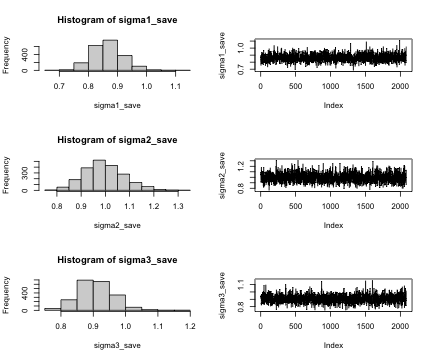

RObject{VecSxp}
$mfrow
[1] 3 2



In [5]:
@rput sigma1_save sigma2_save sigma3_save  
R"""
par(mfrow=c(3,2))
hist(sigma1_save)
plot(sigma1_save, type="l")
hist(sigma2_save)
plot(sigma2_save, type="l")
hist(sigma3_save)
plot(sigma3_save, type="l")
par(mfrow=c(1,1))
"""

In [32]:
l1_save = pos["l1"][keep_index]
e1_save = pos["e1"][keep_index]
l2_save = pos["l2"][keep_index]
e2_save = pos["e2"][keep_index]
l3_save = pos["l3"][keep_index]
e3_save = pos["e3"][keep_index]
s1_save = pos["s1"][keep_index]
p1_save = pos["p1"][keep_index]
s2_save = pos["s2"][keep_index]
p2_save = pos["p2"][keep_index];
# @rput l1_save e1_save
# @rput l2_save e2_save 
# @rput l3_save e3_save 
# @rput s1_save p1_save
# @rput s2_save p2_save 
# R"""
# par(mfrow=c(2,5))
# plot(l1_save, type="l")
# plot(e1_save, type="l")
# plot(l2_save, type="l")
# plot(e2_save, type="l")
# plot(l3_save, type="l")
# plot(e3_save, type="l")
# plot(s1_save, type="l")
# plot(p1_save, type="l")
# plot(s2_save, type="l")
# plot(p2_save, type="l")
# par(mfrow=c(1,1))
# """

In [18]:
T = length(y)
nt = length.(y)

T_grids_pred = range(1, 30, length=300)

1.0:0.09698996655518395:30.0

In [19]:
function posterior_estimates(mu_pos, l_pos, e_pos, sigma_pos, Z_pos, _y_pos, T_grids_int, T, k)
    """
    T_girds_inter: grids for intropolation 
    """
    
    nkeep = length(l_pos) 
    
    mu_est = zeros(nkeep, length(T_grids_int))
    
    @showprogress for i in (1:nkeep)

        T_grids_orig = []
        y_t = []
        for t in 1:T
            index = findall(Z_pos[i][t] .== k)
            nindex = length(index)
            push!(T_grids_orig, fill(t, nindex))
            push!(y_t, _y_pos[i][t][index])
        end
        T_grids_orig = vcat(T_grids_orig...)
        y_t = vcat(y_t...)

        Kvv = get_dist_matrix(T_grids_orig, T_grids_orig, l_pos[i], e_pos[i])
        Kwv = get_dist_matrix(T_grids_int, T_grids_orig, l_pos[i], e_pos[i])
        Kww = get_dist_matrix(T_grids_int, T_grids_int, l_pos[i], e_pos[i])
        Kvv_noisy = Kvv + sigma_pos[i] * I
        Kvv_inv = svd2inv(Kvv_noisy)

        mean = Kwv * Kvv_inv * y_t
        Cov = Kww - Kwv * Kvv_inv * Kwv'

        Cov = stablizeMatrix(Cov)
        mu_est[i,:] = rand(MvNormal(mean, Cov), 1)

    end
    return mu_est 
end

posterior_estimates (generic function with 1 method)

In [20]:
T_grids_pred = range(1, 30, length=300)

1.0:0.09698996655518395:30.0

In [21]:
mu1_est = posterior_estimates(mu1_save, l1_save, e1_save, sigma1_save, Z_save, _y_save, T_grids_pred, T, 1);

Progress: 100%|█████████████████████████████████████████| Time: 0:10:22


In [22]:
mu2_est = posterior_estimates(mu2_save, l2_save, e2_save, sigma2_save, Z_save, _y_save, T_grids_pred, T, 2);

Progress: 100%|█████████████████████████████████████████| Time: 0:11:12


In [33]:
mu3_est = posterior_estimates(mu3_save, l3_save, e3_save, sigma3_save, Z_save, _y_save, T_grids_pred, T, 3);

Progress: 100%|█████████████████████████████████████████| Time: 0:10:26


In [34]:
mu1_truth = 4 .* ones(length(T_grids_pred));
mu2_truth = zeros(length(T_grids_pred));
mu3_truth = -4 .* ones(length(T_grids_pred));

In [35]:
@rput mu1_truth mu2_truth mu3_truth
@rput mu1_est mu2_est mu3_est 
@rput T_grids_pred;

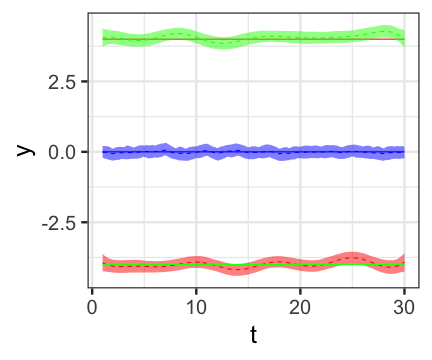

RObject{VecSxp}


In [36]:
R"""
library(ggplot2)
mu1_est_mean = apply(mu1_est, 2, mean)
mu1_est_quan = apply(mu1_est, 2, quantile, prob=c(0.025, 0.975))
mu2_est_mean = apply(mu2_est, 2, mean)
mu2_est_quan = apply(mu2_est, 2, quantile, prob=c(0.025, 0.975))
mu3_est_mean = apply(mu3_est, 2, mean)
mu3_est_quan = apply(mu3_est, 2, quantile, prob=c(0.025, 0.975))

mu_est_df = data.frame(x=T_grids_pred, 
                       l1=mu1_est_quan[1,], h1=mu1_est_quan[2,], m1=mu1_est_mean, t1=mu1_truth, 
                       l2=mu2_est_quan[1,], h2=mu2_est_quan[2,], m2=mu2_est_mean, t2=mu2_truth,
                       l3=mu3_est_quan[1,], h3=mu3_est_quan[2,], m3=mu3_est_mean, t3=mu3_truth)

p_est_mu = ggplot(mu_est_df) 
p_est_mu = p_est_mu + geom_ribbon(aes(x=x,ymin=l1,ymax=h1), fill="red", alpha=0.5)
p_est_mu = p_est_mu + geom_line(aes(x=x,y=m1), color="red", linetype="dashed")
p_est_mu = p_est_mu + geom_line(aes(x=x,y=t1), color="red")

p_est_mu = p_est_mu + geom_ribbon(aes(x=x,ymin=l2,ymax=h2), fill="blue", alpha=0.5)
p_est_mu = p_est_mu + geom_line(aes(x=x,y=m2), color="blue", linetype="dashed")
p_est_mu = p_est_mu + geom_line(aes(x=x,y=t2), color="blue")

p_est_mu = p_est_mu + geom_ribbon(aes(x=x,ymin=l3,ymax=h3), fill="green", alpha=0.5)
p_est_mu = p_est_mu + geom_line(aes(x=x,y=m3), color="green", linetype="dashed")
p_est_mu = p_est_mu + geom_line(aes(x=x,y=t3), color="green")

p_est_mu = p_est_mu + xlab("t") + ylab("y") + theme_bw(base_size=25)
p_est_mu
"""